In [1]:
import os
import sys

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scvelo as scv
from scipy import stats
from scipy.sparse import csr_matrix

import celloracle as co

In [2]:
%matplotlib inline

In [194]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [4]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization

### 0. Load GRN info

In [5]:
# Load file with GRN info
oracle = co.load_hdf5("./Pancreas_grn_sim.celloracle.oracle")

In [6]:
#rename so we do not overwrite the info
oracle.adata.var['grn_score'] = oracle.adata.var['velocity_score'].copy()
oracle.adata.uns['rank_grn_genes'] = oracle.adata.uns['rank_velocity_genes'].copy()

### 1. Estimate velocities

In [7]:
scv.tl.recover_dynamics(oracle.adata, n_jobs = 10)

recovering dynamics (using 10/16 cores)


  0%|          | 0/1298 [00:00<?, ?gene/s]

    finished (0:02:04) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [8]:
#compute velocities
scv.tl.velocity(oracle.adata, mode='dynamical')

computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [9]:
scv.tl.velocity_graph(oracle.adata)

computing velocity graph
    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [10]:
#scv.pl.velocity_embedding_stream(oracle.adata, basis='umap')

## 2. Latent time

In [11]:
scv.tl.latent_time(oracle.adata)
#scv.pl.scatter(oracle.adata, color='latent_time', color_map='gnuplot', size=80)

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


In [12]:
top_genes = oracle.adata.var['fit_likelihood'].sort_values(ascending=False).index#[:300]
#scv.pl.heatmap(oracle.adata, var_names=top_genes, sortby='latent_time', col_color='clusters', n_convolve=100)

In [13]:
scv.tl.rank_dynamical_genes(oracle.adata, groupby='clusters')

ranking genes by cluster-specific likelihoods
    finished (0:00:02) --> added 
    'rank_dynamical_genes', sorted scores by group ids (adata.uns)


In [14]:
# Save oracle object.
oracle.to_hdf5("Pancreas_grn_vel.celloracle.oracle")

## 3. Top-likelihood genes

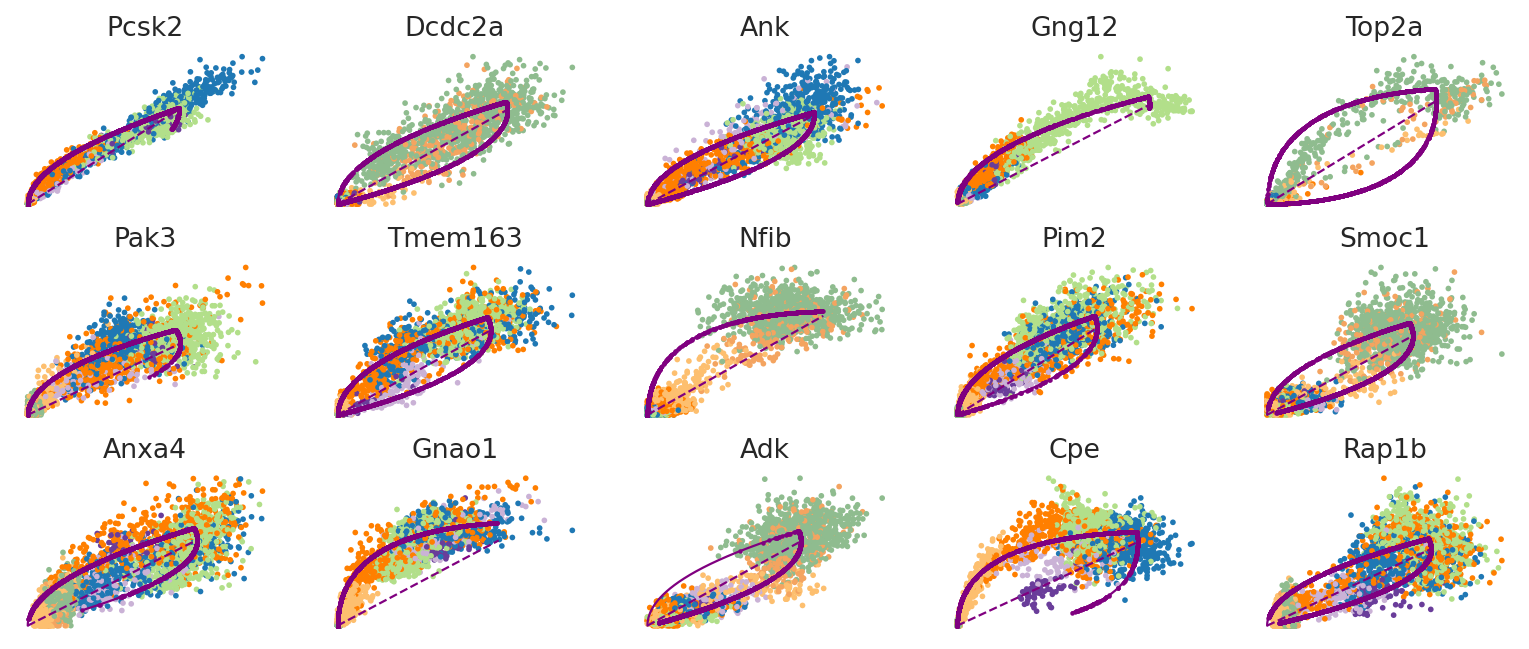

In [15]:
scv.pl.scatter(oracle.adata, basis=top_genes[:15], ncols=5, frameon=False)

In [16]:
top30 = oracle.adata[:,list(top_genes[:30])]

In [17]:
pearson = []
spearman = []

for i in np.arange(30):
    pearson.append(np.corrcoef(np.transpose(top30.layers['grn'])[i], np.transpose(top30.layers['velocity'])[i])[0][1])
    spearman.append(stats.spearmanr(np.transpose(top30.layers['grn'])[i], np.transpose(top30.layers['velocity'])[i])[0])

pearson = np.asarray(pearson)
spearman = np.asarray(spearman)

In [18]:
top30_corr = pd.DataFrame()
top30_corr['gene'] = list(top_genes[:30])
top30_corr['pearson'] = pearson
top30_corr['spearman'] = spearman

<AxesSubplot:>

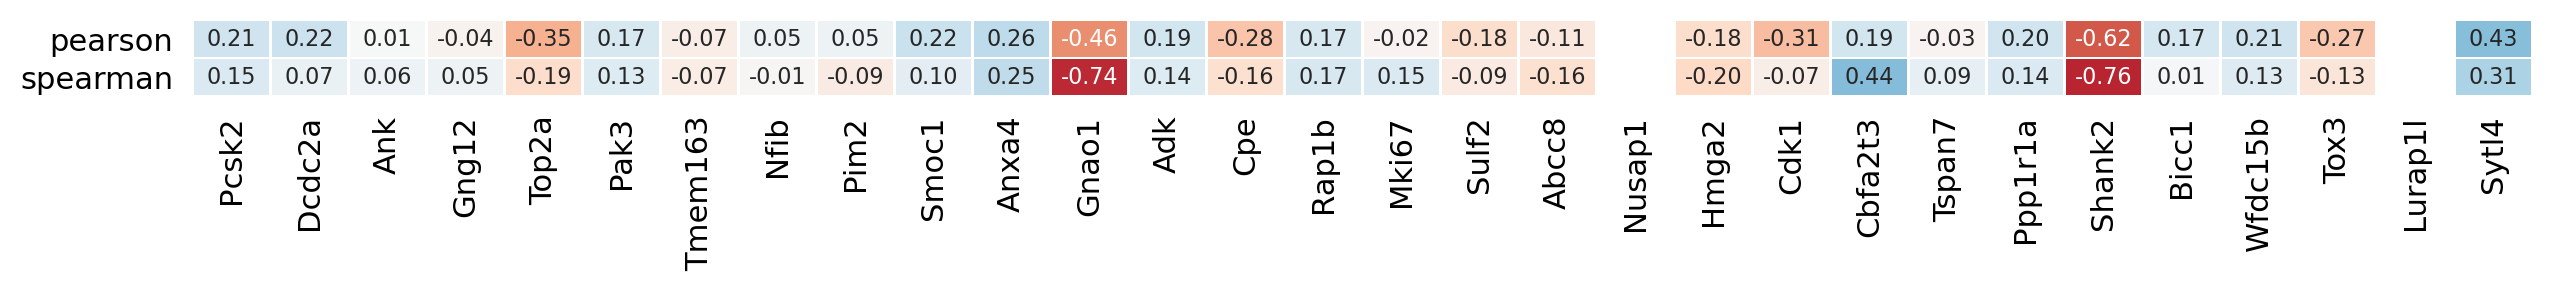

In [19]:
#Correlations
plt.figure(figsize=(15, 0.5))
sns.heatmap(np.asarray(top30_corr[['pearson', 'spearman']]).T.reshape(2,30), 
            xticklabels = np.asarray(top30_corr[['gene']]).reshape(30,), 
            yticklabels = ['pearson', 'spearman'],
            linewidths=.5,
            annot = True,
            fmt=".2f",
            annot_kws={'fontsize':8},
            cbar=False,
            cmap = "RdBu",
            vmin=-1, vmax=1)
#plt.savefig("./figures/top30_corr.png", dpi=150)

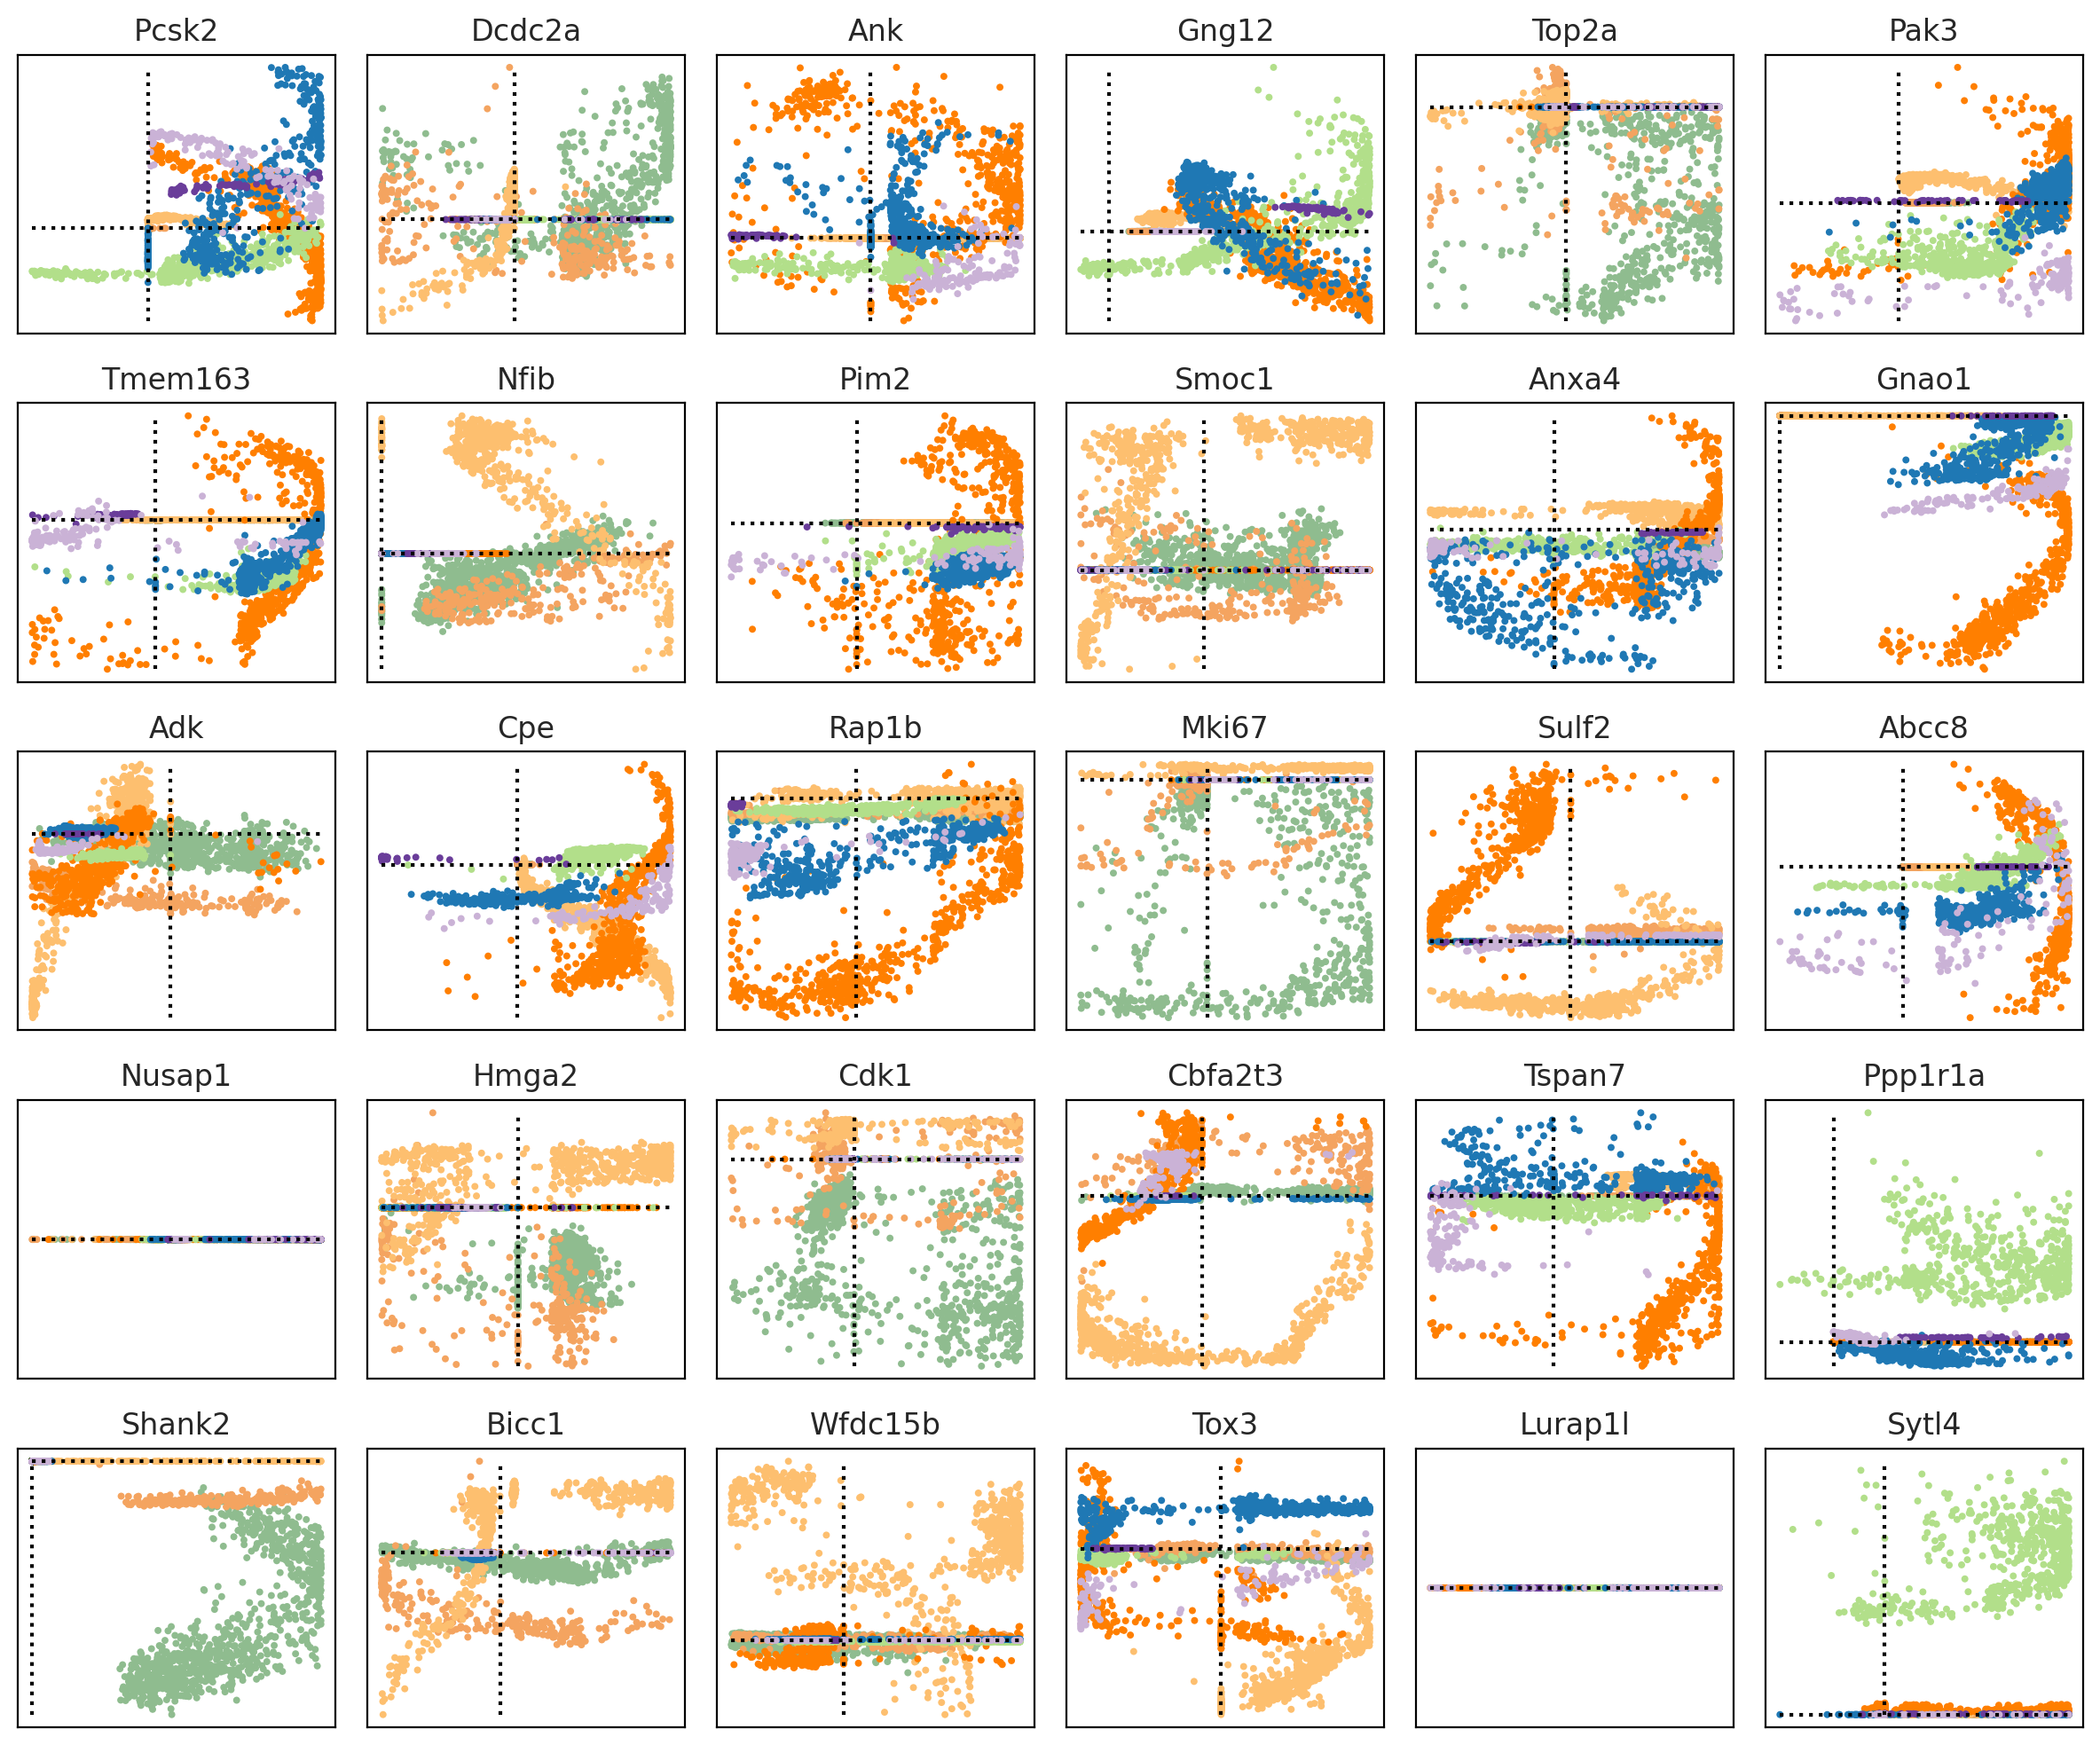

In [20]:
fig, axs = plt.subplots(5, 6, figsize=(12,10),constrained_layout=True)

for i, var in enumerate(top30.var.index):
    if i <6:
        j=0
        k=i
    elif i<12:
        j=1
        k=i-6
    elif i<18:
        j=2
        k=i-12
    elif i<24:
        j=3
        k=i-18
    else:
        j=4
        k=i-24
        
    sc.pl.scatter(top30, x=var, y=var, layers=('velocity','grn','velocity'), color='clusters',show=False, ax=axs[j,k])
    min_vel = min(np.transpose(top30.layers['velocity'])[i])
    max_vel = max(np.transpose(top30.layers['velocity'])[i])
    min_grn = min(np.transpose(top30.layers['grn'])[i])
    max_grn = max(np.transpose(top30.layers['grn'])[i])
    #axs[j,k].plot([min_grn,max_grn],[min_grn,max_grn], 'k:')
    axs[j,k].plot([0,0],[min_grn,max_grn], 'k:')
    axs[j,k].plot([min_vel,max_vel],[0,0], 'k:')
    axs[j,k].set_title(var)
    axs[j,k].set_xlabel('')
    axs[j,k].set_ylabel('')
    axs[j,k].get_legend().remove()
    axs[j,k].get_xaxis().set_ticks([])
    axs[j,k].get_yaxis().set_ticks([])
    #axs[j,k].axis('off')
plt.savefig("./figures/top30_grn_vel.png", dpi=150)

### Genes with no information

They are not transcription factors nor targets associated to any of them. Information is missing.

Maybe we could think about SCENIC's approach, were we used only a list of TFs as regressors and then the ranking databases for prunning.

Trying to set attribute `.layers` of view, copying.


saving figure to file ./figures/scvelo_absent_velocity.png


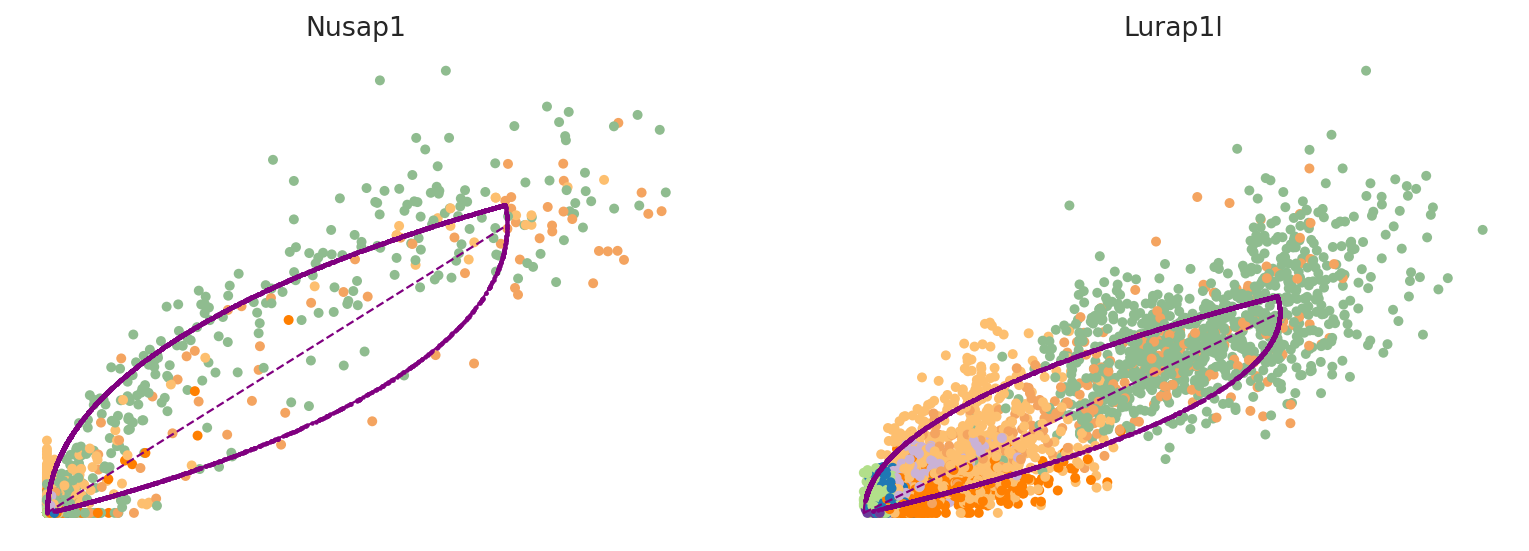

saving figure to file ./figures/scvelo_absent_time.png


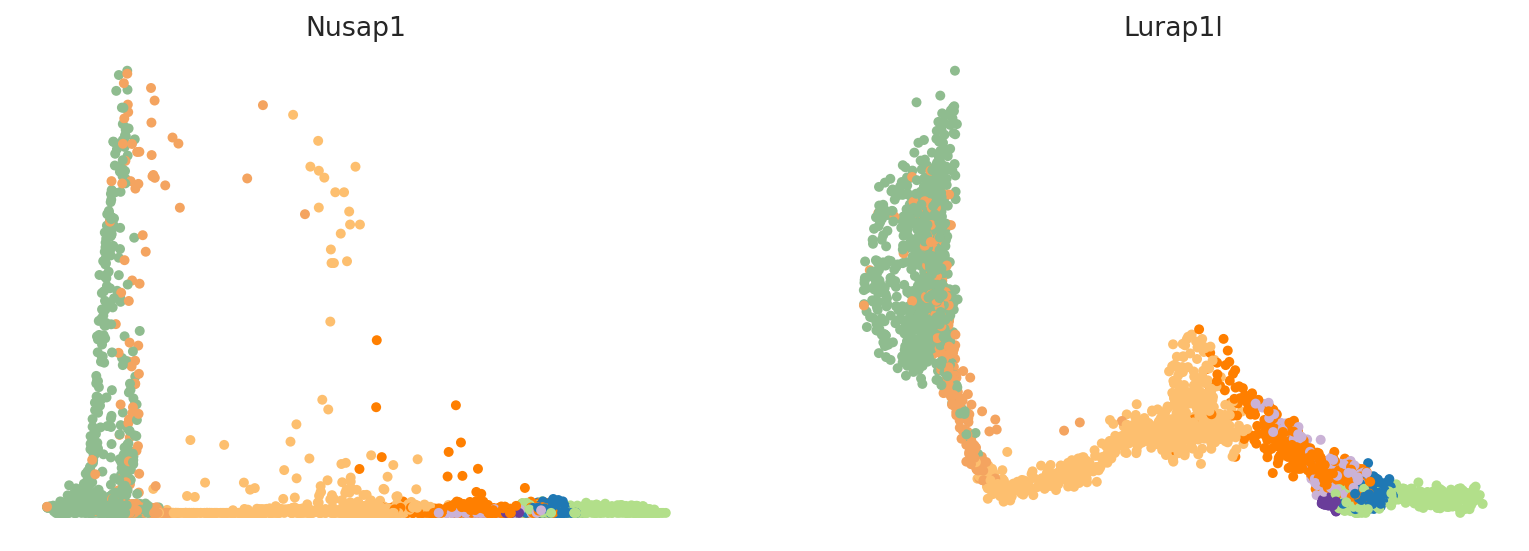

In [21]:
var_names = ['Nusap1', 'Lurap1l']
scv.pl.scatter(top30, var_names, frameon=False, size= 80, dpi = 150, save='absent_velocity.png')
scv.pl.scatter(top30, x='latent_time', y=var_names, frameon=False, size= 80, dpi=150, save='absent_time.png')

In [22]:
#data frame with the velocities of the top30 likelihood genes
top30_vel_df = pd.DataFrame(top30.layers['velocity'])
top30_vel_df.columns = np.asarray(top30.var.index)
top30_vel_df['cluster'] = np.asarray(top30.obs['clusters'])
top30_vel_df.head()

Pcsk2    Dcdc2a       Ank     Gng12     Top2a      Pak3   Tmem163  \
0  1.203516 -0.079694  0.290264  0.523420 -0.058277  0.182395  0.224112   
1  0.001838  0.163419  0.430770  0.107878  0.330124  0.040183  0.237062   
2  1.125103 -0.041489 -0.306211  0.320194 -0.000000  0.221916  0.176007   
3  0.000000  0.436701 -0.032245  0.081866  0.538652  0.028689  0.004379   
4  0.493762 -0.009498  0.098838  0.249810 -0.033556  0.207856  0.168435   

       Nfib      Pim2     Smoc1  ...   Cbfa2t3    Tspan7   Ppp1r1a    Shank2  \
0  0.000000  0.228801 -0.066766  ... -0.061478  0.394896  0.773522  0.000000   
1  0.059343  0.546700  0.098818  ...  0.504194  0.492194  0.007367  0.033733   
2  0.015609  0.569758 -0.116363  ... -0.065704 -0.378496  0.160690  0.000000   
3  0.088563  0.031713  0.109039  ... -0.014266  0.179846  0.007873  0.051212   
4  0.046944  0.352551  0.171773  ... -0.509239  0.605948  0.036218  0.000000   

      Bicc1   Wfdc15b      Tox3   Lurap1l     Sytl4        cluster  
0 -0.197991 -0.087237 -0.538321 -0.121613  0.088744  Pre-endocrine  
1  0.174533 -0.055782  0.002489 -0.188922  0.041541         Ductal  
2 -0.121717  0.270049 -0.562575 -0.112193  0.425526          Alpha  
3 -0.416115 -0.187813 -0.341082  0.500181 -0.029788         Ductal  
4 -0.045935 -0.059165  0.000000 -0.320760 -0.026155   Ngn3 high EP  

[5 rows x 31 columns]

In [23]:
sns.set_theme(style="whitegrid")
colors = top30.uns['clusters_colors']
order = ['Ductal','Ngn3 low EP', 'Ngn3 high EP', 'Pre-endocrine', 'Beta', 'Alpha', 'Delta', 'Epsilon']

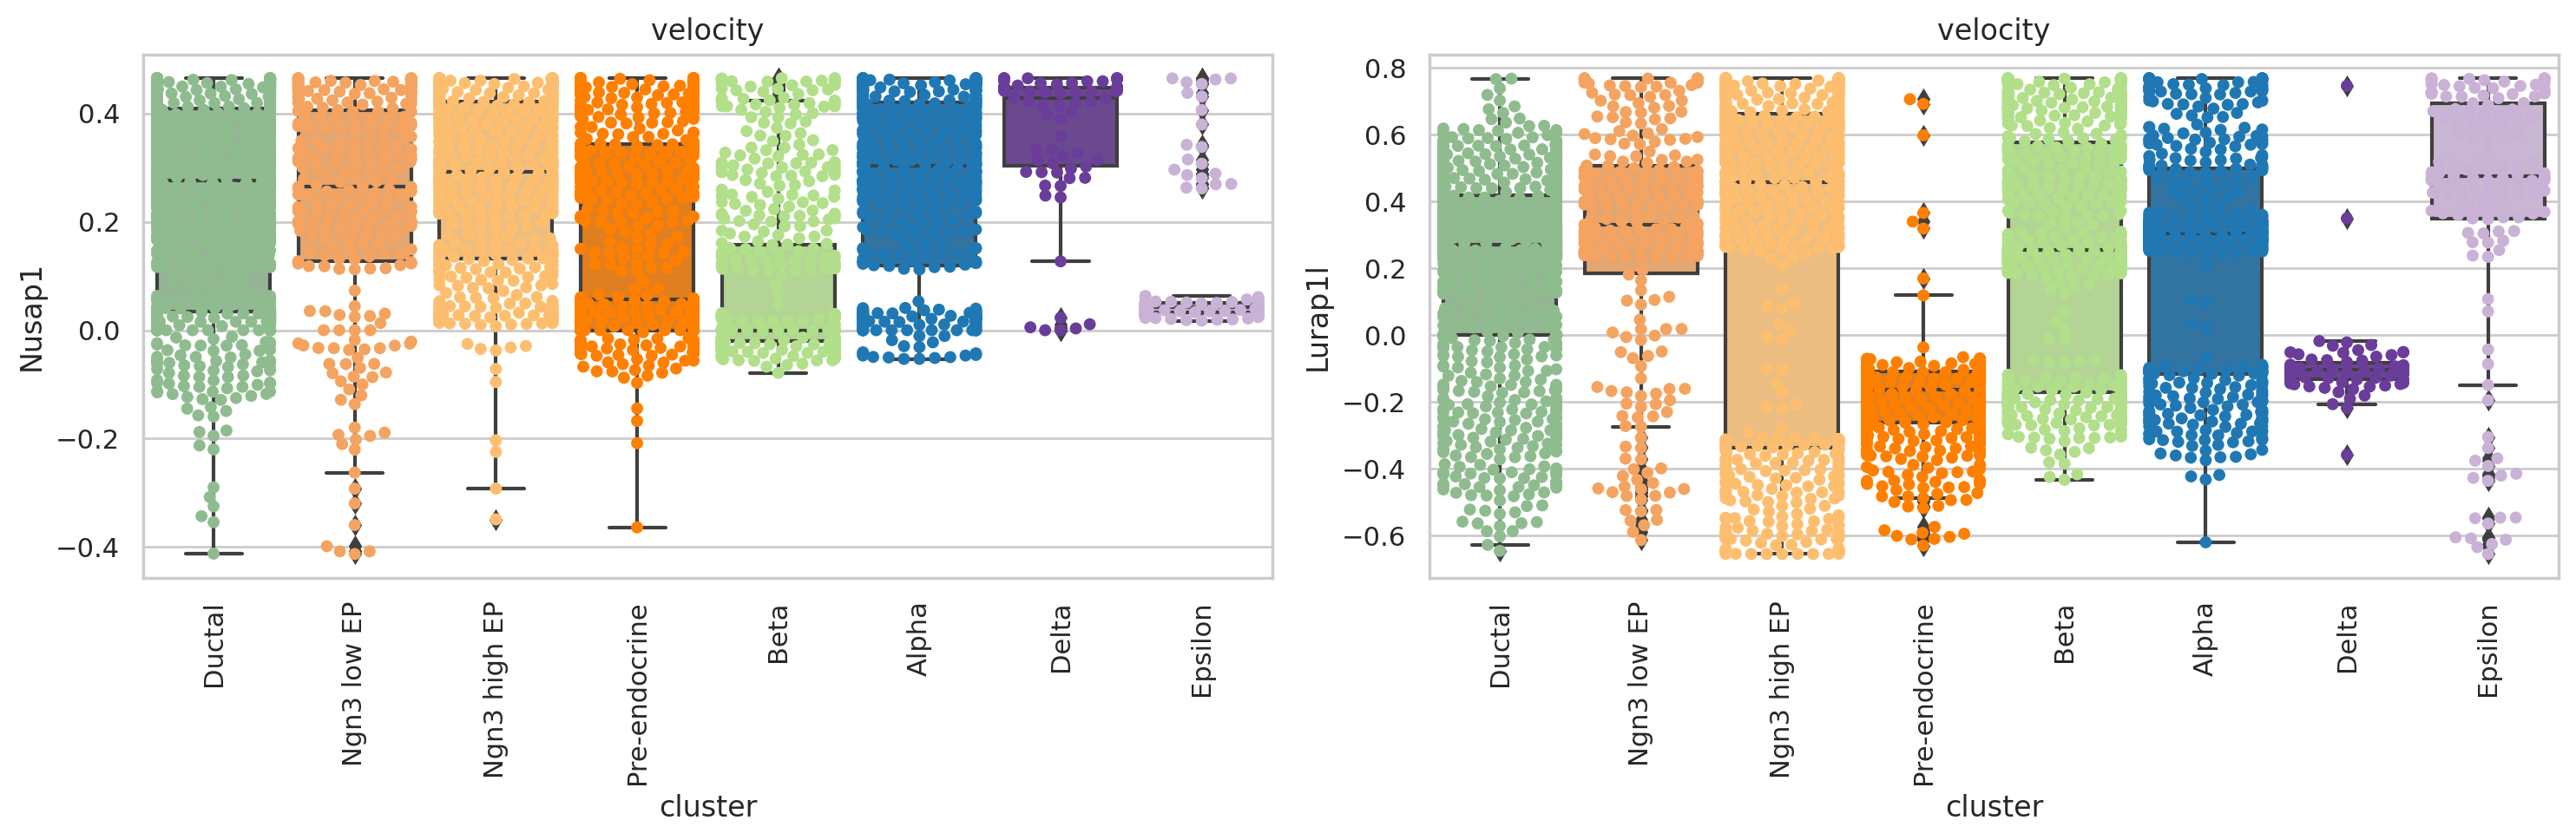

In [24]:
f, axs = plt.subplots(1,2,figsize=(15,5))

for i,var in enumerate(['Nusap1','Lurap1l']):
    axs[i] = sns.swarmplot(x="cluster", y=var, data=top30_vel_df, palette=colors, order= order, ax=axs[i])
    axs[i] = sns.boxplot(x="cluster", y=var, data=top30_vel_df, palette=colors,order = order, ax=axs[i])
    axs[i].set_title('velocity')
    axs[i].set_xticklabels(labels=order, rotation=90)
plt.savefig("./figures/boxplot_absent.jpg")

In [25]:
oracle.coef_matrix_per_cluster['Ductal']['Lurap1l'] #is not a TF and is not a target of any of them

Sntg1      0.0
Snhg6      0.0
Ncoa2      0.0
Sbspon     0.0
Ube2w      0.0
          ... 
Tmem27     0.0
Uty        0.0
Ddx3y      0.0
Eif2s3y    0.0
Erdr1      0.0
Name: Lurap1l, Length: 2000, dtype: float64

### Genes opposite direction

In [26]:
sns.reset_orig()

saving figure to file ./figures/scvelo_wrong_velocity.png


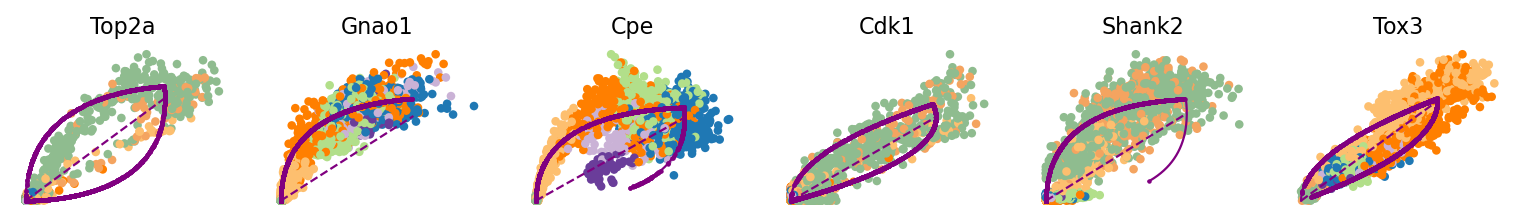

saving figure to file ./figures/scvelo_wrong_time.png


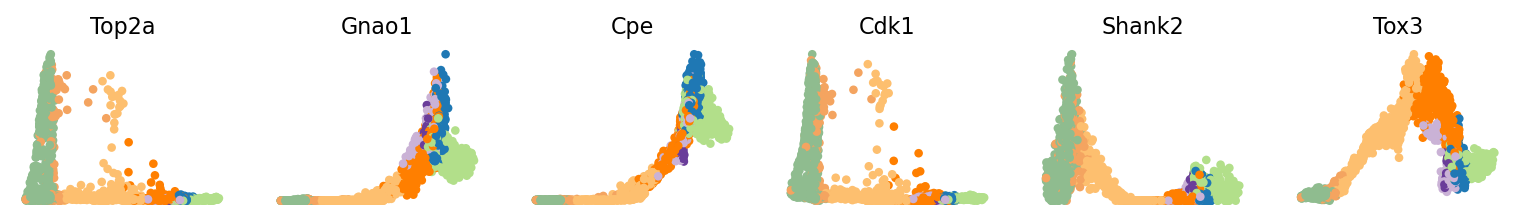

In [70]:
var_names = ['Top2a', 'Gnao1', 'Cpe', 'Cdk1', 'Shank2', 'Tox3']
scv.pl.scatter(top30, var_names, frameon=False, size= 60, dpi = 150, save='wrong_velocity.png')
scv.pl.scatter(top30, x='latent_time', y=var_names, frameon=False, size= 60, dpi=150, save='wrong_time.png')

In [28]:
indices = np.asarray(top30_corr.index[top30_corr['gene'].isin(var_names)])

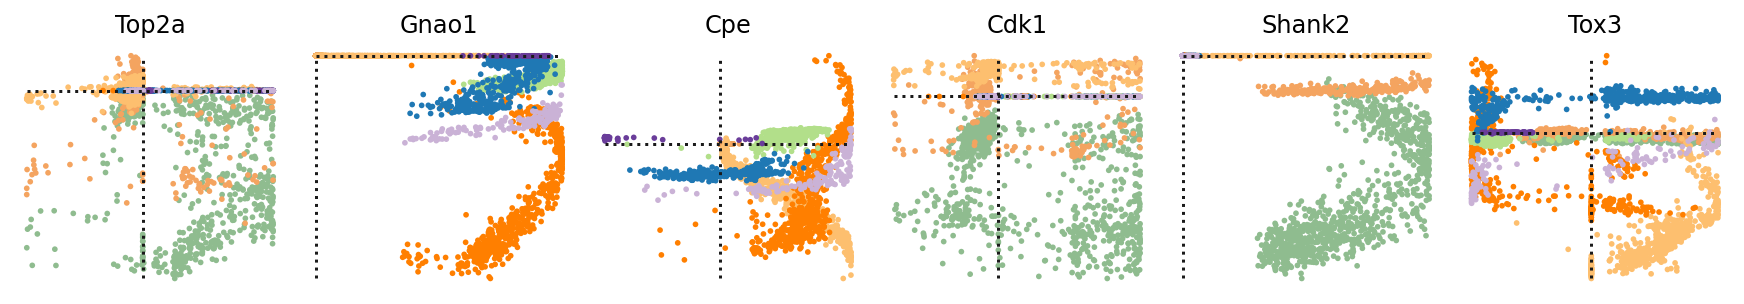

In [29]:
fig, axs = plt.subplots(1, 6, figsize=(12,2),constrained_layout=True)

for i,var in enumerate(var_names):
    j=indices[i]
    sc.pl.scatter(top30, x=var, y=var, layers=('velocity','grn','velocity'), color='clusters',show=False, ax=axs[i])
    axs[i].set_title(var)
    axs[i].set_xlabel('velocity')
    axs[i].set_ylabel('grn')
    axs[i].get_legend().remove()
    axs[i].axis('off')
    min_vel = min(np.transpose(top30.layers['velocity'])[j])
    max_vel = max(np.transpose(top30.layers['velocity'])[j])
    min_grn = min(np.transpose(top30.layers['grn'])[j])
    max_grn = max(np.transpose(top30.layers['grn'])[j])
    axs[i].plot([0,0],[min_grn,max_grn], 'k:')
    axs[i].plot([min_vel,max_vel],[0,0], 'k:')

plt.savefig("./figures/top30_grn_wrong.png", dpi=150)

In [30]:
#top30 velocity melt
top30_vel_df_melt = top30_vel_df.melt(value_vars = top30_vel_df.columns[:30], id_vars=['cluster'])
#top30 grn melt
top30_grn_df = pd.DataFrame(top30.layers['grn'])
top30_grn_df.columns = np.asarray(top30.var.index)
top30_grn_df['cluster'] = np.asarray(top30.obs['clusters'])
top30_grn_df_melt = top30_grn_df.melt(value_vars = top30_grn_df.columns[:30], id_vars=['cluster'])
#top30 velocity + grn melt
top30_grn_vel_df = top30_grn_df_melt.merge(top30_vel_df_melt, left_index=True, right_index=True, suffixes=('_grn', '_vel'))
top30_grn_vel_df = top30_grn_vel_df.drop(['cluster_vel','variable_vel'], axis=1)
top30_grn_vel_df.columns = ['cluster','gene','grn','vel']
top30_grn_vel_df['id']=top30_grn_vel_df.index
top30_grn_vel_df_melt = top30_grn_vel_df.melt(id_vars=['id','gene','cluster'], value_vars=['grn','vel']).drop(['id'], axis=1)

In [31]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

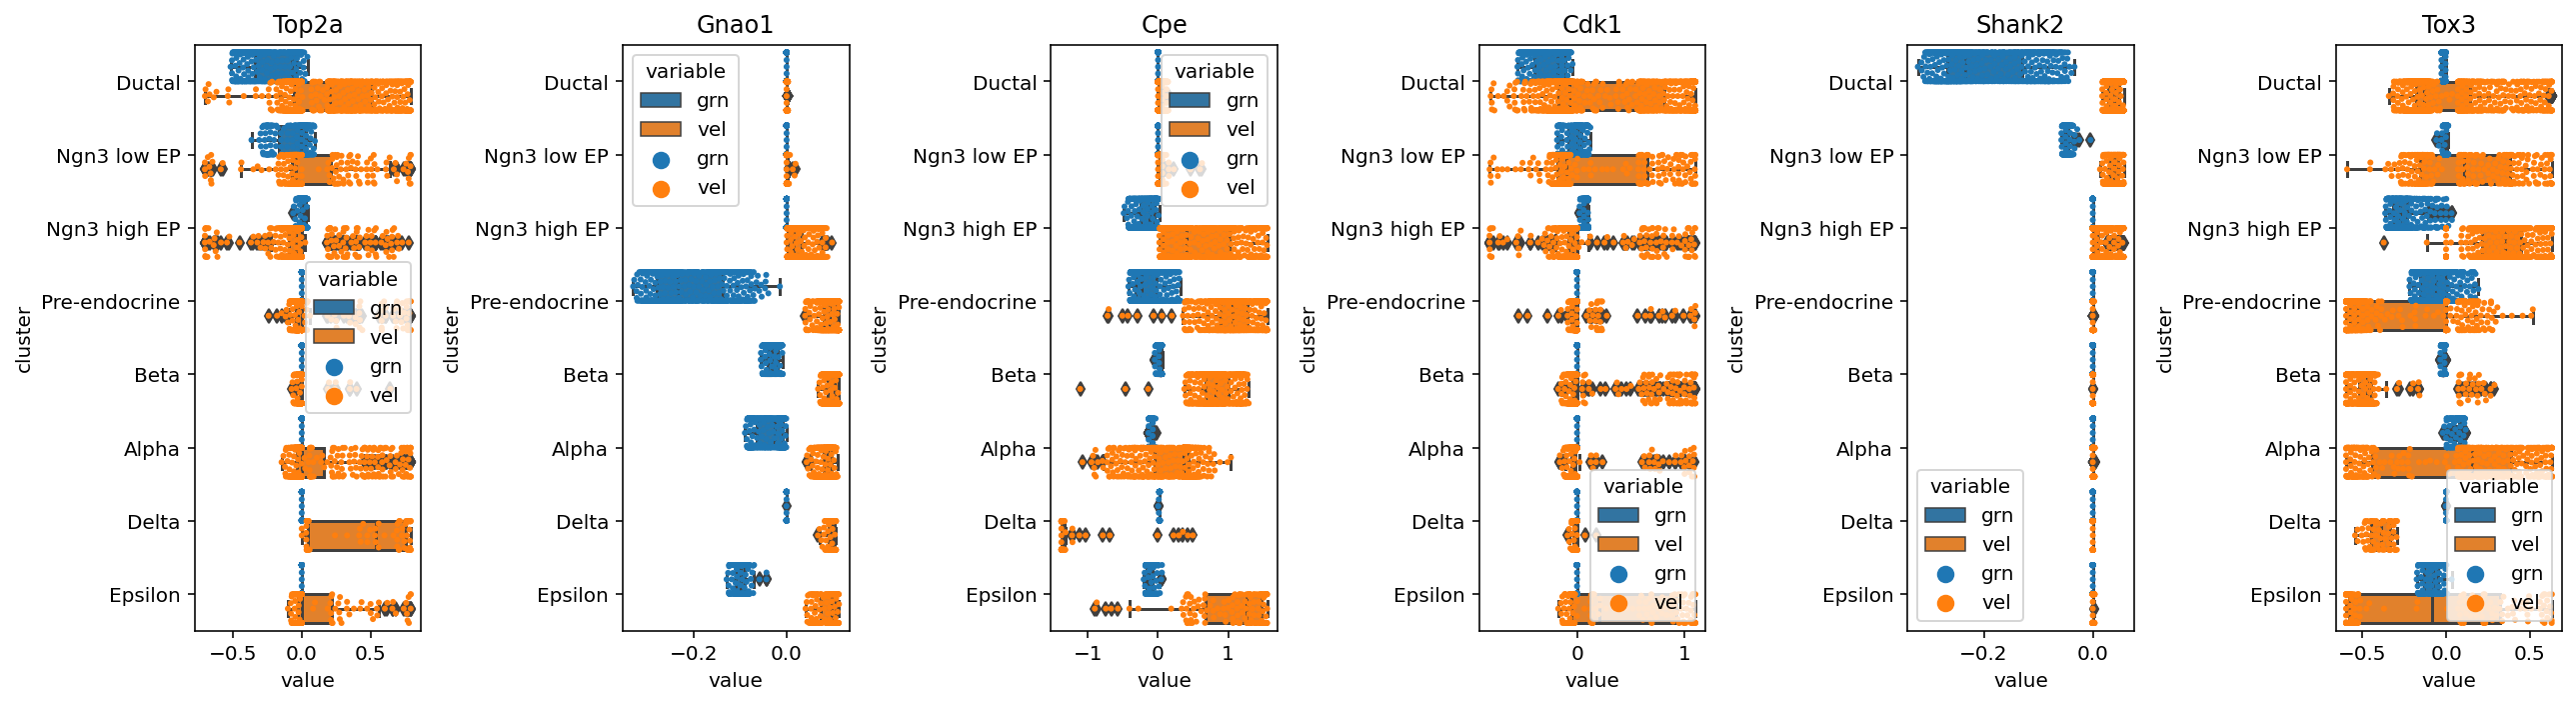

In [32]:
f, axs = plt.subplots(1,6,figsize=(18,5))

for i,var in enumerate(var_names):
    var_df = top30_grn_vel_df_melt[top30_grn_vel_df_melt.gene == var]
    axs[i] = sns.swarmplot(y="cluster", x='value', data=var_df, hue='variable', order=order, dodge=True, orient='h', size=3, ax=axs[i])
    axs[i] = sns.boxplot(y="cluster", x='value', data=var_df, hue='variable', order=order, orient='h', ax=axs[i])
    axs[i].set_title(var)
plt.savefig("./figures/wrong_grn_vel.jpg")

Let's see how the expression looks in all of the clusters

In [35]:
#Cluster labels per cell
cluster_info = oracle.adata.obs['clusters']

In [103]:
#imputed count
gem_imputed = pd.DataFrame(oracle.adata.layers['imputed_count'], columns = oracle.adata.var.index.values, index=oracle.adata.obs.index.values)
gem_imputed['cluster'] = np.asarray(top30.obs['clusters'])
gem_imputed_df_melt = gem_imputed.melt(value_vars = gem_imputed.columns[:2000], id_vars=['cluster'])
#simulated count
gem_simulated = pd.DataFrame(oracle.adata.layers['simulated_count'], columns = oracle.adata.var.index.values, index=oracle.adata.obs.index.values)
gem_simulated['cluster'] = np.asarray(top30.obs['clusters'])
gem_simulated_df_melt = gem_simulated.melt(value_vars = gem_simulated.columns[:2000], id_vars=['cluster'])
#imputed + simulated melt
gem_df = gem_imputed_df_melt.merge(gem_simulated_df_melt, left_index=True, right_index=True, suffixes=('_im', '_sim'))
gem_df = gem_df.drop(['cluster_im','variable_im'], axis=1)
gem_df.columns = ['imputed','cluster','gene','simulated']
gem_df['id']=gem_df.index
gem_df_melt = gem_df.melt(id_vars=['id','gene','cluster'], value_vars=['imputed','simulated']).drop(['id'], axis=1)

In [104]:
gem_df_melt.head()

gene        cluster variable  value
0  Sntg1  Pre-endocrine  imputed    0.0
1  Sntg1         Ductal  imputed    0.0
2  Sntg1          Alpha  imputed    0.0
3  Sntg1         Ductal  imputed    0.0
4  Sntg1   Ngn3 high EP  imputed    0.0

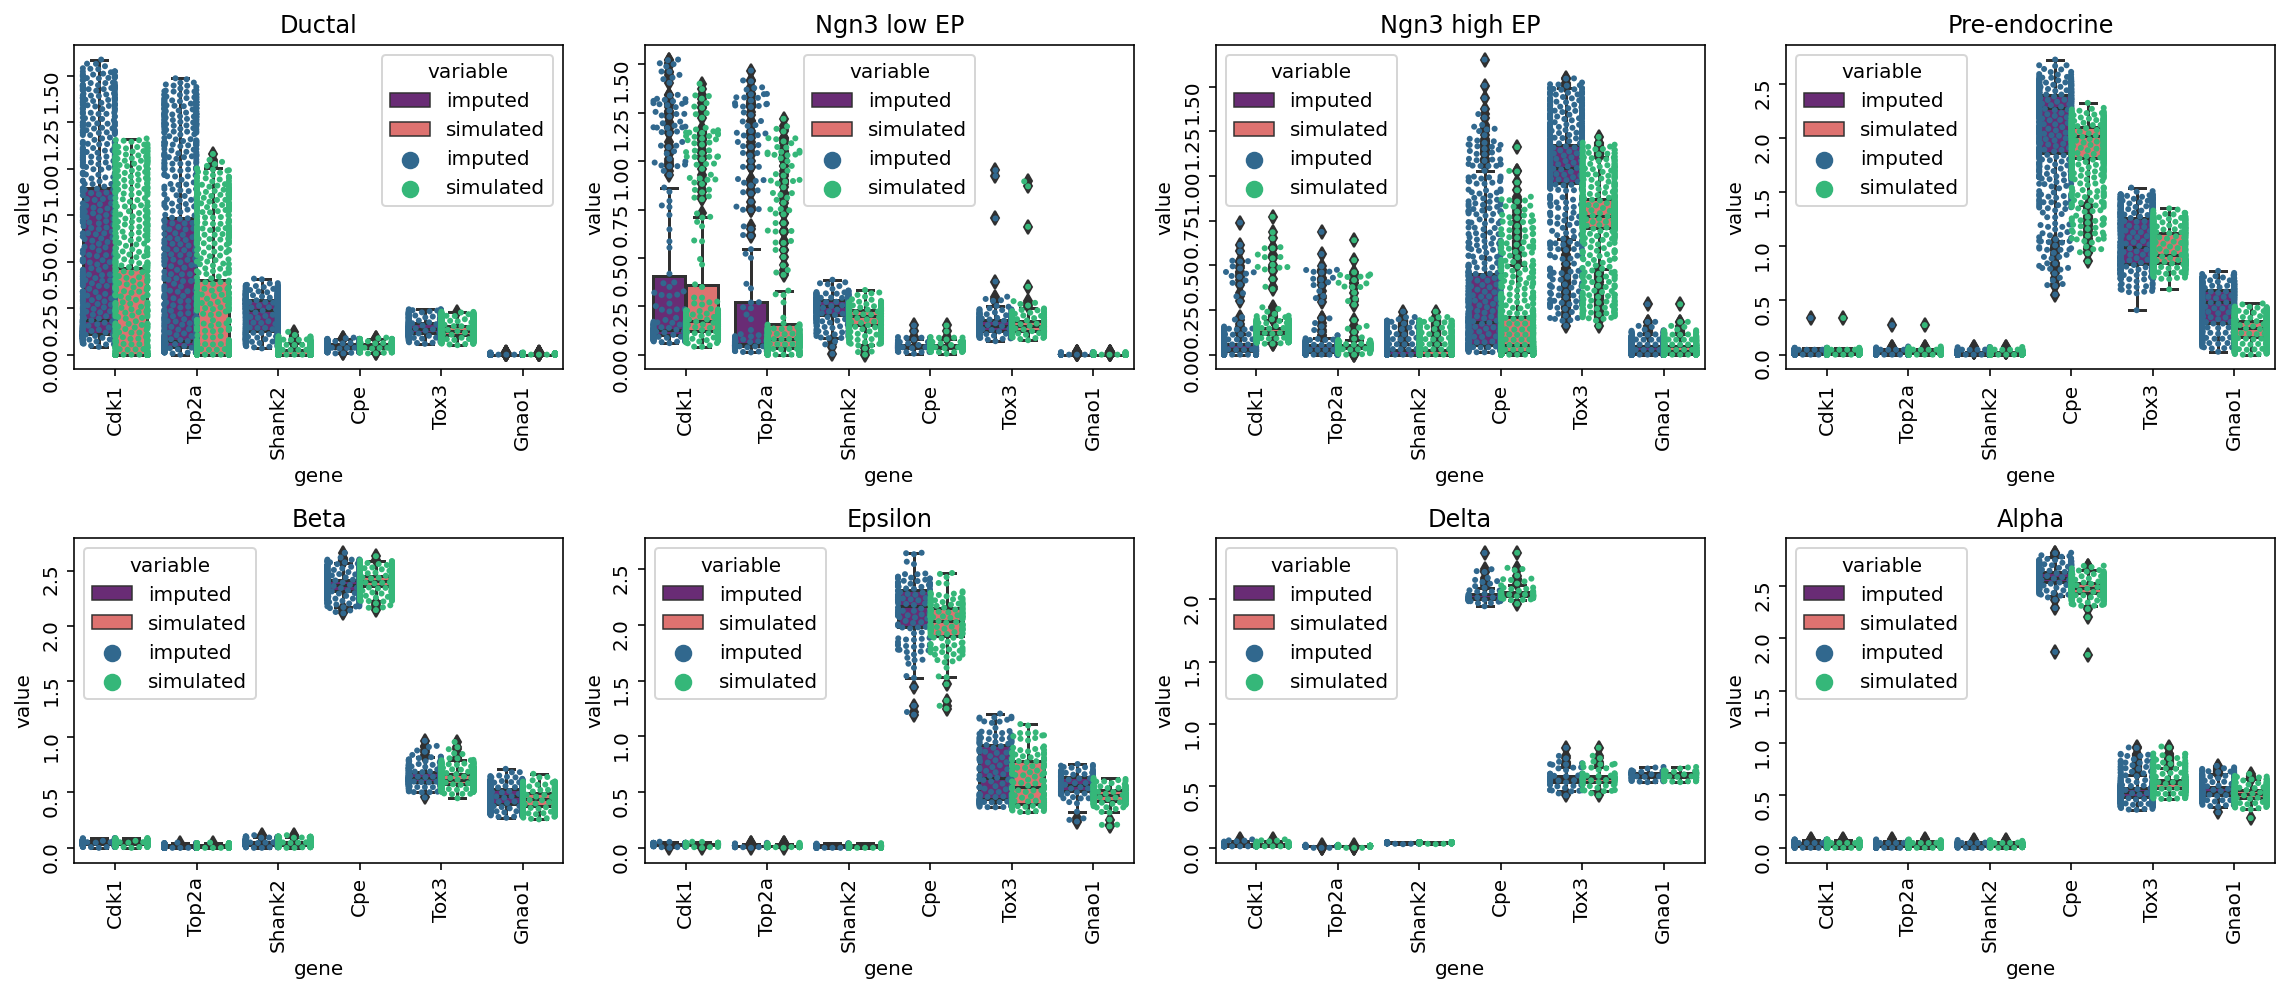

In [129]:
f, axs = plt.subplots(2,4,figsize=(16,7))

for i,clus in enumerate(order):
    if i <4:
        j=0
        k=i
    else:
        j=1
        k=4-i
    var_df = gem_df_melt[gem_df_melt.cluster == clus][gem_df_melt['gene'].isin(var_names)]
    sns.swarmplot(x="gene", y='value', data=var_df, hue='variable', dodge=True, orient='v', size=3, ax=axs[j,k], palette='viridis')
    sns.boxplot(x="gene", y='value', data=var_df, hue='variable', orient='v', ax=axs[j,k], palette='magma')
    axs[j,k].set_title(clus)
    axs[j,k].tick_params(labelrotation=90)
plt.savefig("./figures/wrong_grn_ex.jpg")

In [131]:
set1 = ['Top2a', 'Cdk1','Shank2']
set2 = ['Gnao1', 'Cpe']

In [152]:
coefs_ductal_set1 = oracle.coef_matrix_per_cluster['Ductal'][set1]
coefs_low_set1 = oracle.coef_matrix_per_cluster['Ngn3 low EP'][set1]

In [153]:
coefs_ductal_set1 = coefs_ductal_set1[(coefs_ductal_set1.T != 0).any()]
coefs_ductal_set1['max_abs'] = coefs_ductal_set1.abs().max(axis=1)
coefs_ductal_set1=coefs_ductal_set1.sort_values(by='max_abs', ascending=False)
coefs_ductal_set1 = coefs_ductal_set1.drop('max_abs', axis=1)
coefs_ductal_set1['gene']=coefs_ductal_set1.index
coefs_ductal_set1_melt = coefs_ductal_set1.melt(value_vars = set1, id_vars=['gene'])

In [154]:
coefs_ductal_set1_melt

gene variable     value
0       Ezh2    Top2a  0.423203
1      Hmgb2    Top2a  0.457053
2      Kdm5b    Top2a  0.000000
3      Nr2f6    Top2a  0.180552
4      Meis2    Top2a  0.069301
..       ...      ...       ...
175  Slc18a1   Shank2  0.000000
176     Rab7   Shank2 -0.008748
177    Kdm5a   Shank2  0.000000
178    Nr4a2   Shank2  0.006337
179      Vdr   Shank2  0.000000

[180 rows x 3 columns]

In [161]:
sns.set_style("whitegrid")

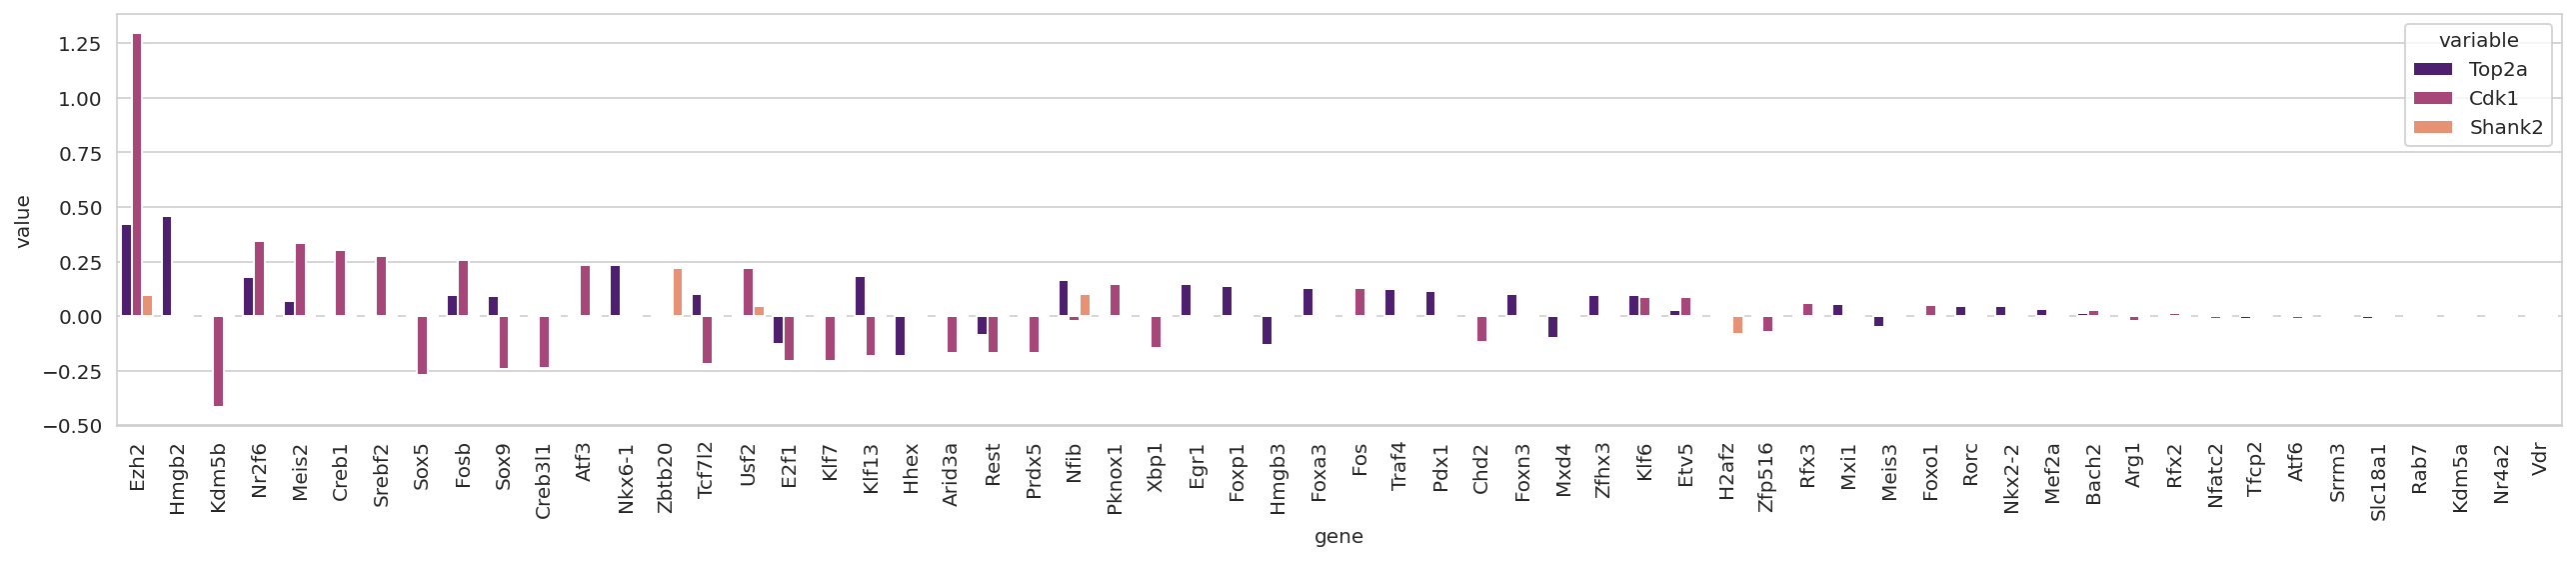

In [163]:
plt.figure(figsize=(18,4))
sns.barplot(x='gene', y='value', hue='variable', data = coefs_ductal_set1_melt, palette='magma')
plt.xticks(rotation=90)
plt.savefig("./figures/wrong_coefs_ductal_set1.jpg")

In [164]:
gem_df_melt[gem_df_melt.cluster == 'Ductal'][gem_df_melt['gene']=='Ezh2']

gene cluster   variable     value
5451601   Ezh2  Ductal    imputed  0.412868
5451603   Ezh2  Ductal    imputed  0.629636
5451605   Ezh2  Ductal    imputed  0.328232
5451607   Ezh2  Ductal    imputed  0.589856
5451608   Ezh2  Ductal    imputed  0.717629
...        ...     ...        ...       ...
12847277  Ezh2  Ductal  simulated  0.390324
12847279  Ezh2  Ductal  simulated  0.656265
12847284  Ezh2  Ductal  simulated  0.599756
12847286  Ezh2  Ductal  simulated  0.341763
12847293  Ezh2  Ductal  simulated  0.301399

[1832 rows x 4 columns]

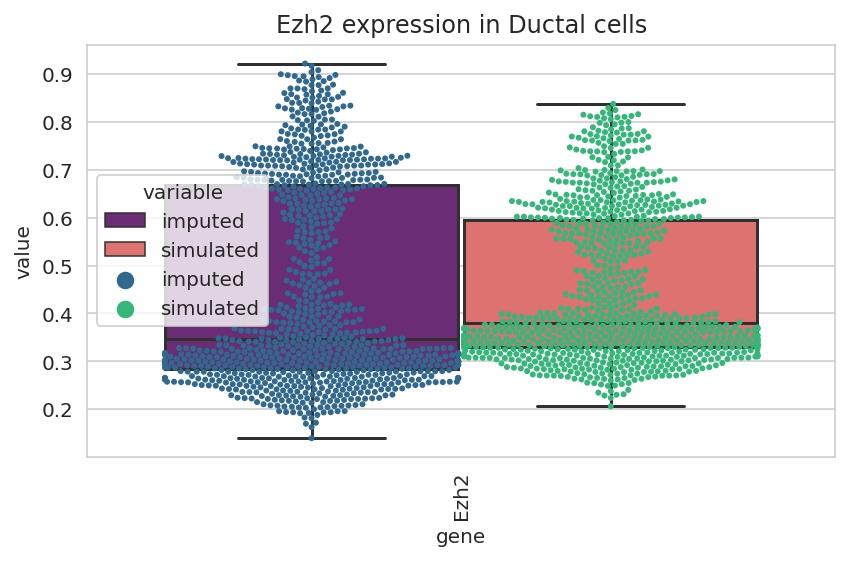

In [165]:
var_df = gem_df_melt[gem_df_melt.cluster == 'Ductal'][gem_df_melt['gene']=='Ezh2']
sns.swarmplot(x="gene", y='value', data=var_df, hue='variable', dodge=True, orient='v', size=3, palette='viridis')
sns.boxplot(x="gene", y='value', data=var_df, hue='variable', orient='v', palette='magma')
plt.title('Ezh2 expression in Ductal cells')
plt.xticks(rotation=90)
plt.savefig("./figures/ezh2_ductal_exp.jpg")

In [193]:
sns.reset_orig()
rcParams.update({'figure.autolayout': True})

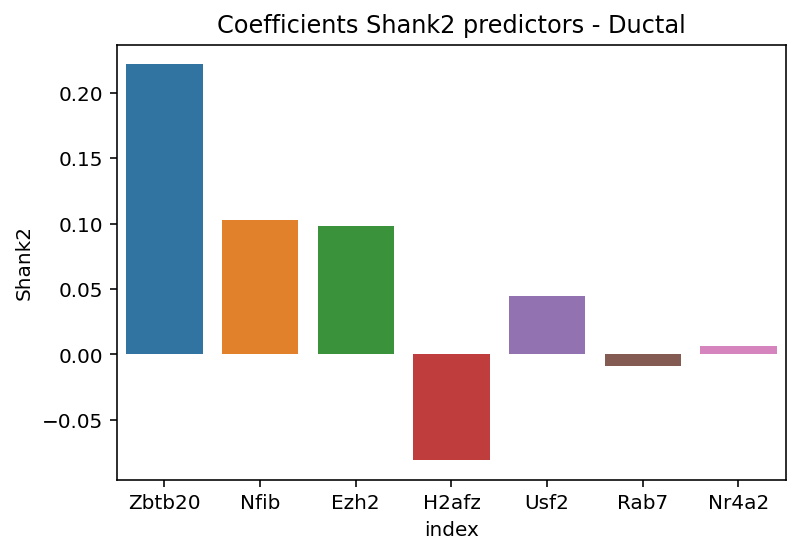

In [184]:
temp = oracle.coef_matrix_per_cluster['Ductal']['Shank2']
temp = pd.DataFrame(temp[temp!=0]).reset_index()
temp['abs'] = np.abs(temp['Shank2'])
temp = temp.sort_values(by='abs', ascending=False)
sns.barplot(data=temp, x='index', y='Shank2')
plt.title('Coefficients Shank2 predictors - Ductal')
plt.savefig("./figures/ductal_shank2_coefs.jpg")

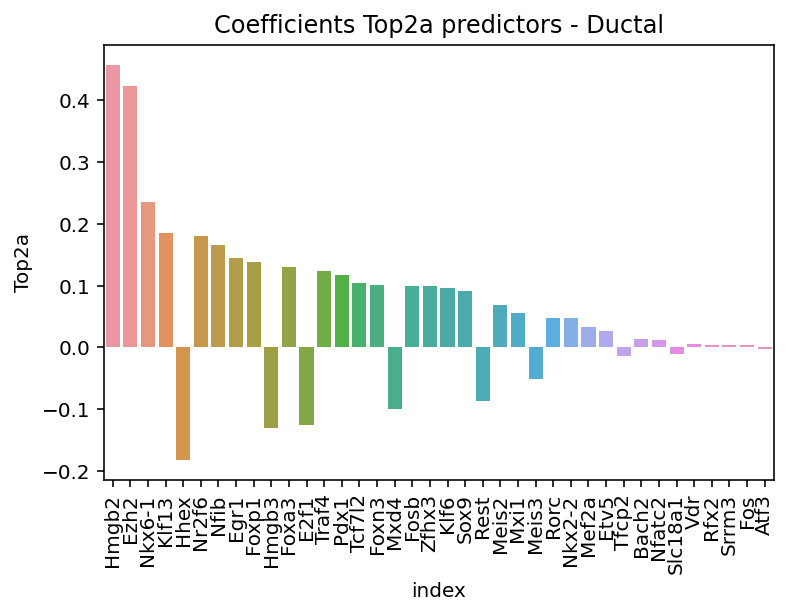

In [185]:
temp = oracle.coef_matrix_per_cluster['Ductal']['Top2a']
temp = pd.DataFrame(temp[temp!=0]).reset_index()
temp['abs'] = np.abs(temp['Top2a'])
temp = temp.sort_values(by='abs', ascending=False)
sns.barplot(data=temp, x='index', y='Top2a')
plt.xticks(rotation=90)
plt.title('Coefficients Top2a predictors - Ductal')
plt.savefig("./figures/ductal_top2a_coefs.jpg")

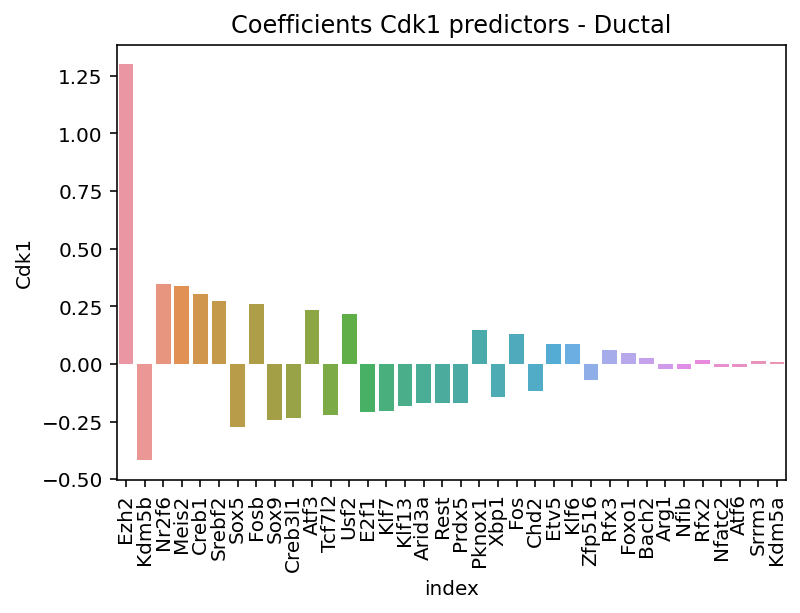

In [186]:
temp = oracle.coef_matrix_per_cluster['Ductal']['Cdk1']
temp = pd.DataFrame(temp[temp!=0]).reset_index()
temp['abs'] = np.abs(temp['Cdk1'])
temp = temp.sort_values(by='abs', ascending=False)
sns.barplot(data=temp, x='index', y='Cdk1')
plt.xticks(rotation=90)
plt.title('Coefficients Cdk1 predictors - Ductal')
plt.savefig("./figures/ductal_cdk1_coefs.jpg")

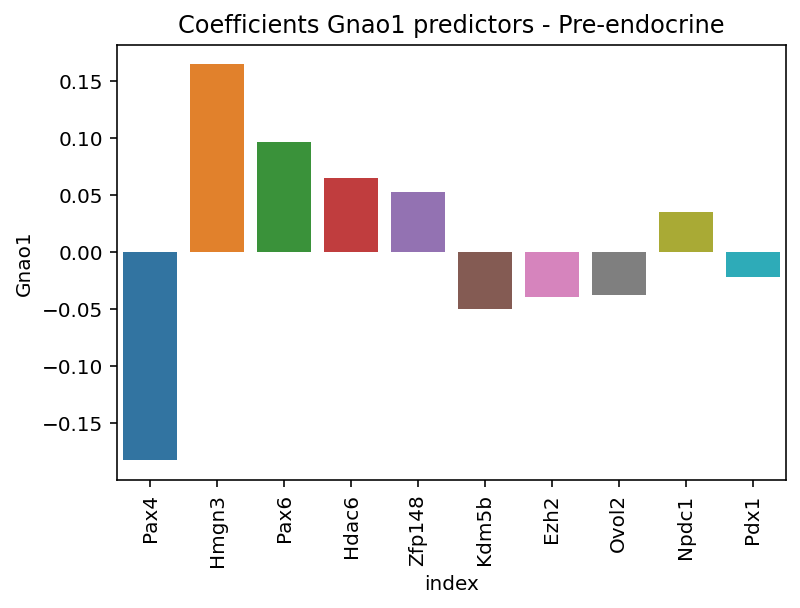

In [187]:
temp = oracle.coef_matrix_per_cluster['Pre-endocrine']['Gnao1']
temp = pd.DataFrame(temp[temp!=0]).reset_index()
temp['abs'] = np.abs(temp['Gnao1'])
temp = temp.sort_values(by='abs', ascending=False)
sns.barplot(data=temp, x='index', y='Gnao1')
plt.xticks(rotation=90)
plt.title('Coefficients Gnao1 predictors - Pre-endocrine')
plt.savefig("./figures/pre-endocrine_gnao1_coefs.jpg")

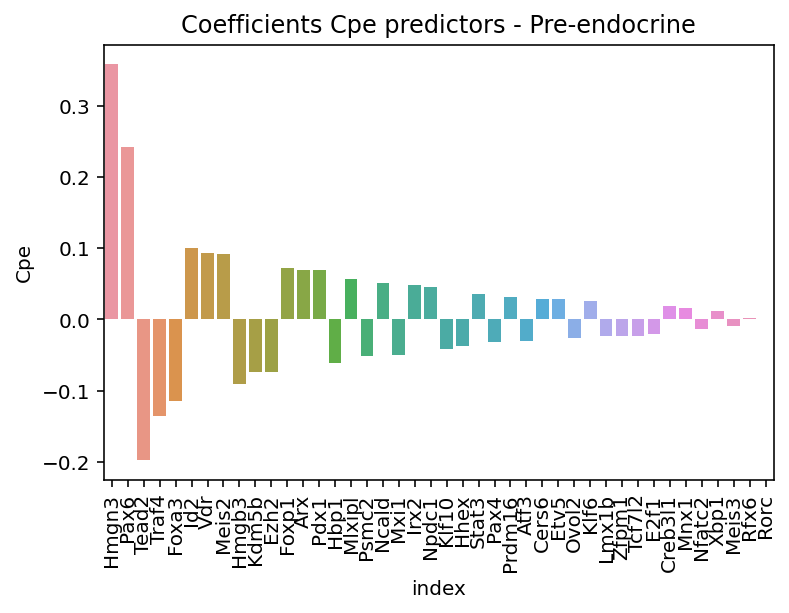

In [188]:
temp = oracle.coef_matrix_per_cluster['Pre-endocrine']['Cpe']
temp = pd.DataFrame(temp[temp!=0]).reset_index()
temp['abs'] = np.abs(temp['Cpe'])
temp = temp.sort_values(by='abs', ascending=False)
sns.barplot(data=temp, x='index', y='Cpe')
plt.xticks(rotation=90)
plt.title('Coefficients Cpe predictors - Pre-endocrine')
plt.savefig("./figures/pre-endocrine_cpe_coefs.jpg")

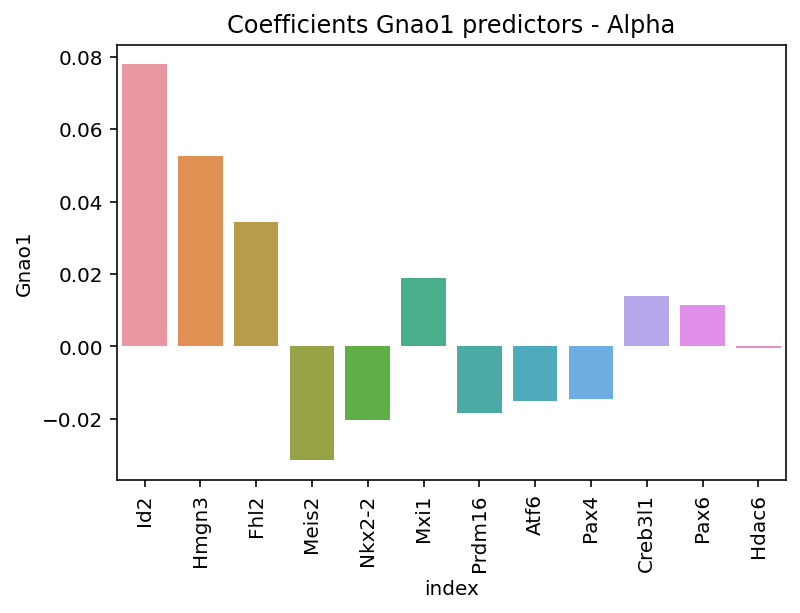

In [189]:
temp = oracle.coef_matrix_per_cluster['Alpha']['Gnao1']
temp = pd.DataFrame(temp[temp!=0]).reset_index()
temp['abs'] = np.abs(temp['Gnao1'])
temp = temp.sort_values(by='abs', ascending=False)
sns.barplot(data=temp, x='index', y='Gnao1')
plt.xticks(rotation=90)
plt.title('Coefficients Gnao1 predictors - Alpha')
plt.savefig("./figures/alpha_gnao1_coefs.jpg")

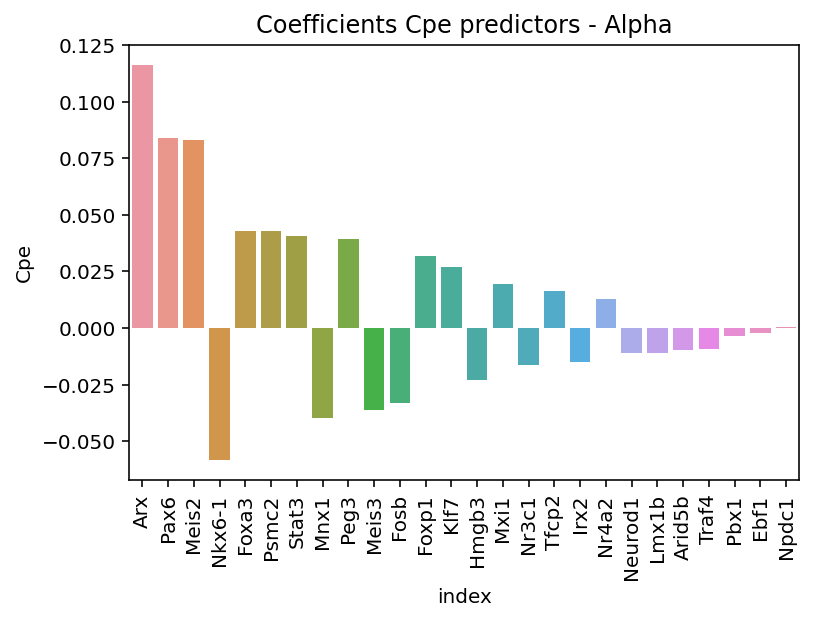

In [190]:
temp = oracle.coef_matrix_per_cluster['Alpha']['Cpe']
temp = pd.DataFrame(temp[temp!=0]).reset_index()
temp['abs'] = np.abs(temp['Cpe'])
temp = temp.sort_values(by='abs', ascending=False)
sns.barplot(data=temp, x='index', y='Cpe')
plt.xticks(rotation=90)
plt.title('Coefficients Cpe predictors - Alpha')
plt.savefig("./figures/alpha_cpe_coefs.jpg")

Why a lot of the grn-displacements are zero?

In [ ]:
#load GRNs, which were saved in the Links obect
links = co.load_hdf5("./links.celloracle.links")

In [ ]:
high_shank2_coefs = pd.DataFrame(oracle.coef_matrix_per_cluster['Ngn3 high EP']['Shank2'][oracle.coef_matrix_per_cluster['Ngn3 high EP']['Shank2']!=0]).reset_index()
high_shank2_coefs

In [ ]:
high_shank2_coefs_orig = links.links_dict['Ngn3 high EP'][links.links_dict['Ngn3 high EP']['target']=='Shank2']
high_shank2_coefs_orig.sort_values(by='p', ascending=False)
#simply, none of the predictors are significant.

### Genes same direction

saving figure to file ./figures/scvelo_right_velocity.png


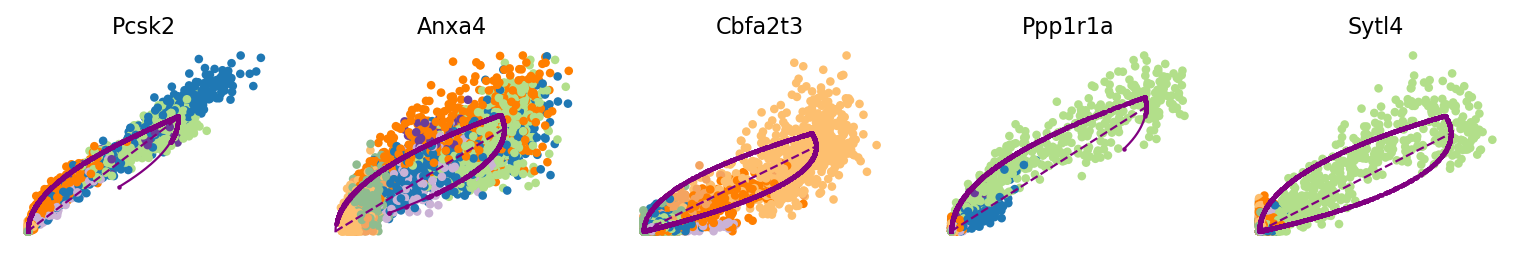

saving figure to file ./figures/scvelo_right_time.png


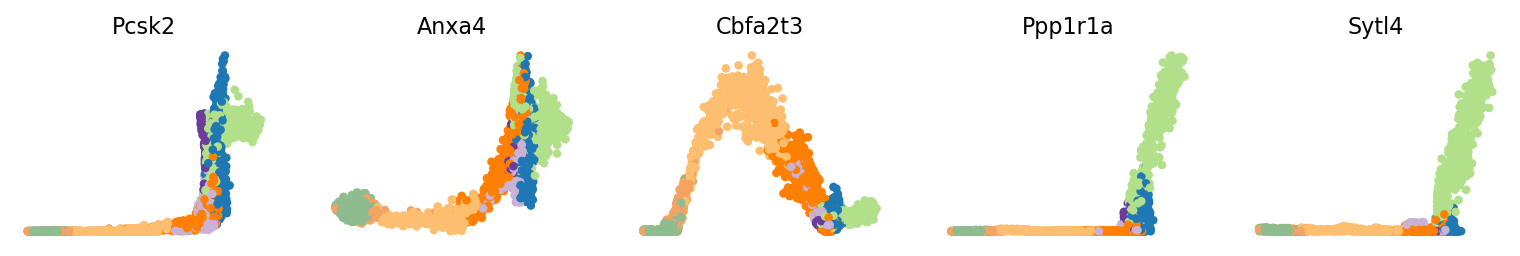

In [167]:
var_names = ['Pcsk2', 'Anxa4', 'Cbfa2t3', 'Ppp1r1a', 'Sytl4']
scv.pl.scatter(top30, var_names, frameon=False, size= 60, dpi = 150, save='right_velocity.png')
scv.pl.scatter(top30, x='latent_time', y=var_names, frameon=False, size= 60, dpi=150, save='right_time.png')

In [168]:
indices = np.asarray(top30_corr.index[top30_corr['gene'].isin(var_names)])

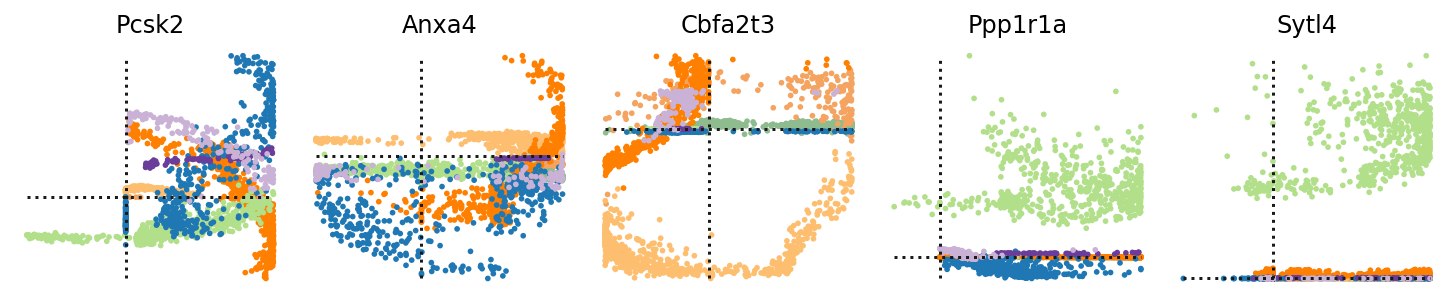

In [169]:
fig, axs = plt.subplots(1, 5, figsize=(10,2),constrained_layout=True)

for i,var in enumerate(var_names):
    j=indices[i]
    sc.pl.scatter(top30, x=var, y=var, layers=('velocity','grn','velocity'), color='clusters',show=False, ax=axs[i])
    axs[i].set_title(var)
    axs[i].set_xlabel('velocity')
    axs[i].set_ylabel('grn')
    axs[i].get_legend().remove()
    axs[i].axis('off')
    min_vel = min(np.transpose(top30.layers['velocity'])[j])
    max_vel = max(np.transpose(top30.layers['velocity'])[j])
    min_grn = min(np.transpose(top30.layers['grn'])[j])
    max_grn = max(np.transpose(top30.layers['grn'])[j])
    axs[i].plot([0,0],[min_grn,max_grn], 'k:')
    axs[i].plot([min_vel,max_vel],[0,0], 'k:')

plt.savefig("./figures/top30_grn_same.png", dpi=150)

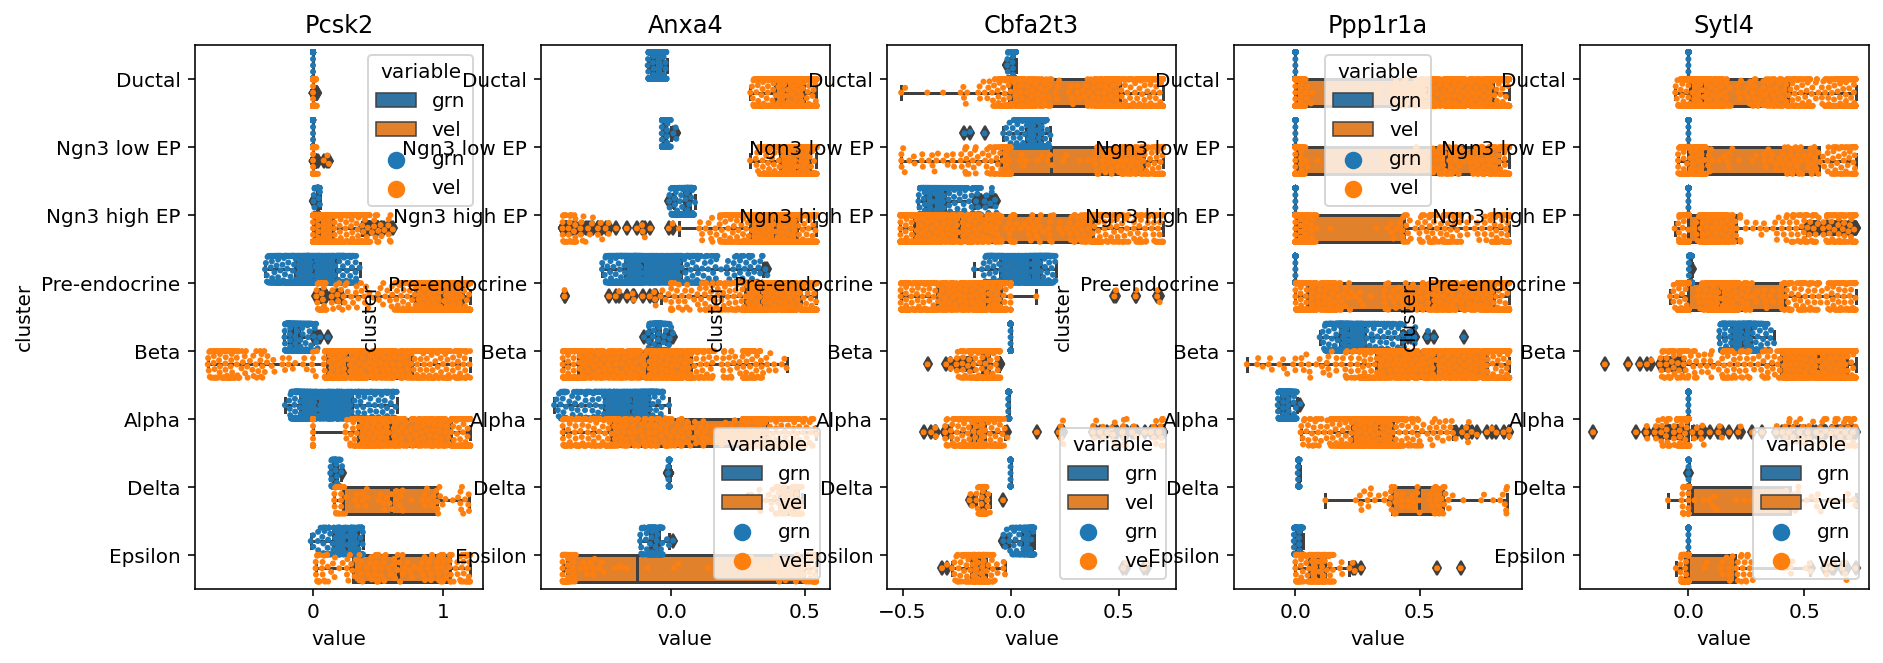

In [171]:
f, axs = plt.subplots(1,5,figsize=(15,5))

for i,var in enumerate(var_names):
    var_df = top30_grn_vel_df_melt[top30_grn_vel_df_melt.gene == var]
    axs[i] = sns.swarmplot(y="cluster", x='value', data=var_df, hue='variable', order=order, dodge=True, orient='h', size=3, ax=axs[i])
    axs[i] = sns.boxplot(y="cluster", x='value', data=var_df, hue='variable', order=order, orient='h', ax=axs[i])
    axs[i].set_title(var)
    #axs[i].set_xticklabels(labels=order, rotation=90)
plt.savefig("./figures/right_grn_vel.jpg")

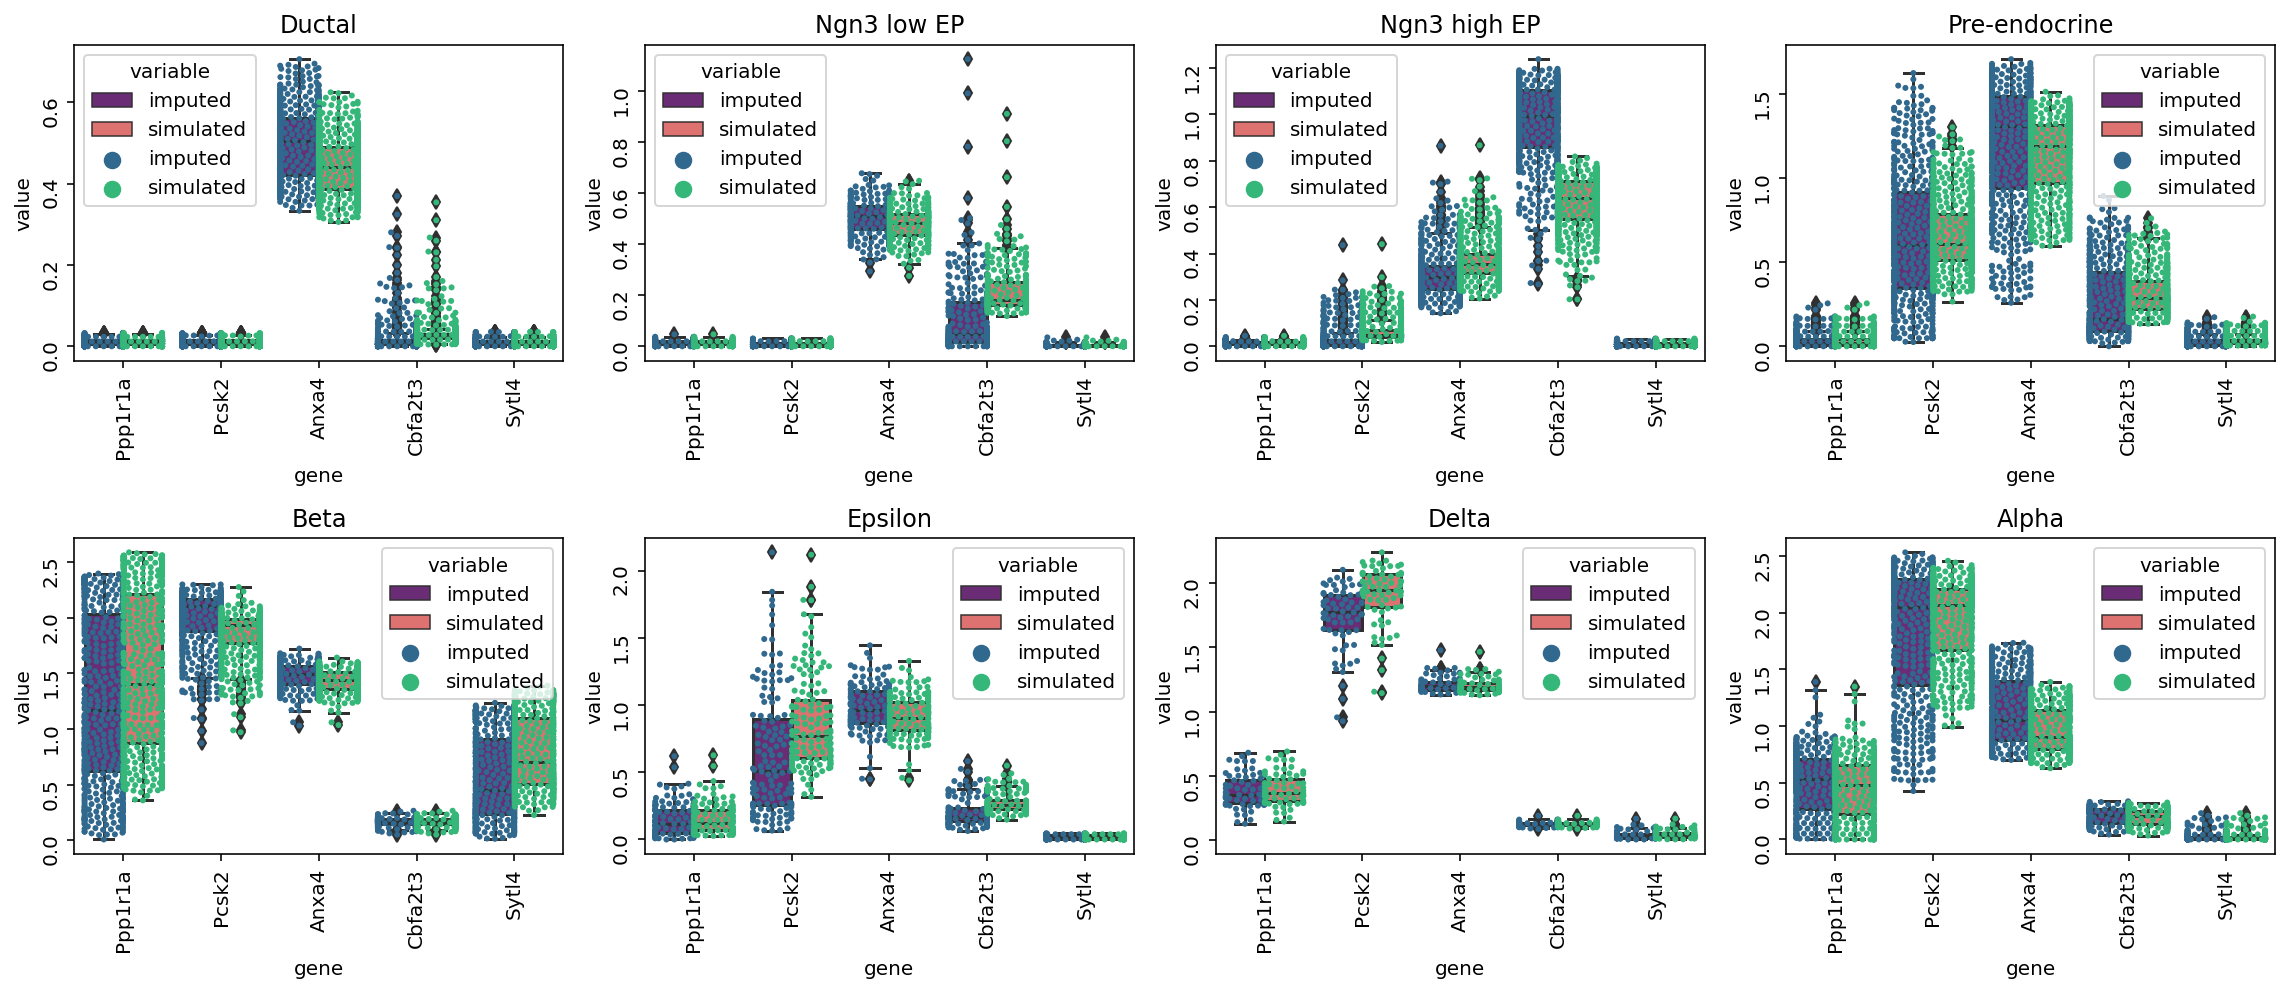

In [195]:
f, axs = plt.subplots(2,4,figsize=(16,7))

for i,clus in enumerate(order):
    if i <4:
        j=0
        k=i
    else:
        j=1
        k=4-i
    var_df = gem_df_melt[gem_df_melt.cluster == clus][gem_df_melt['gene'].isin(var_names)]
    sns.swarmplot(x="gene", y='value', data=var_df, hue='variable', dodge=True, orient='v', size=3, ax=axs[j,k], palette='viridis')
    sns.boxplot(x="gene", y='value', data=var_df, hue='variable', orient='v', ax=axs[j,k], palette='magma')
    axs[j,k].set_title(clus)
    axs[j,k].tick_params(labelrotation=90)
plt.savefig("./figures/right_grn_ex.jpg")

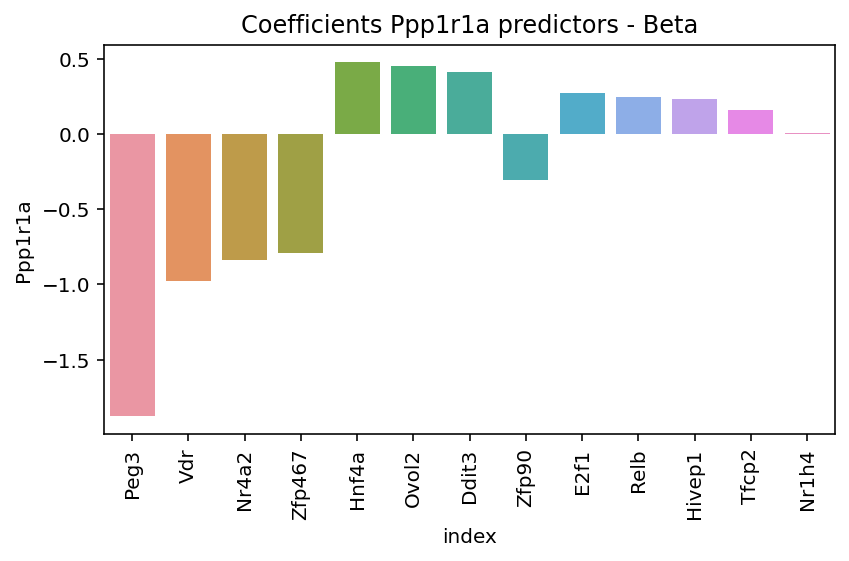

In [198]:
temp = oracle.coef_matrix_per_cluster['Beta']['Ppp1r1a']
temp = pd.DataFrame(temp[temp!=0]).reset_index()
temp['abs'] = np.abs(temp['Ppp1r1a'])
temp = temp.sort_values(by='abs', ascending=False)
sns.barplot(data=temp, x='index', y='Ppp1r1a')
plt.title('Coefficients Ppp1r1a predictors - Beta')
plt.xticks(rotation=90)
plt.savefig("./figures/beta_ppp1r1a_coefs.jpg")

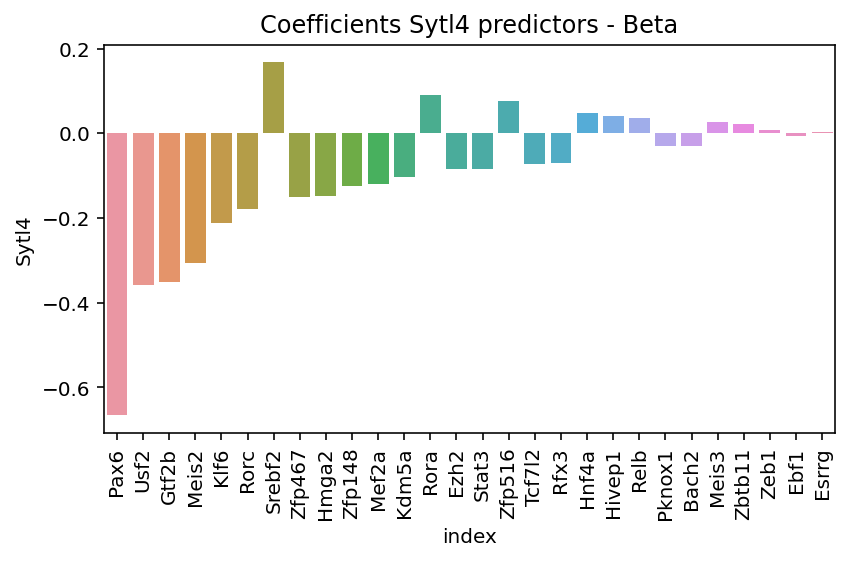

In [199]:
temp = oracle.coef_matrix_per_cluster['Beta']['Sytl4']
temp = pd.DataFrame(temp[temp!=0]).reset_index()
temp['abs'] = np.abs(temp['Sytl4'])
temp = temp.sort_values(by='abs', ascending=False)
sns.barplot(data=temp, x='index', y='Sytl4')
plt.title('Coefficients Sytl4 predictors - Beta')
plt.xticks(rotation=90)
plt.savefig("./figures/beta_sytl4_coefs.jpg")